In [1]:
%%capture
!pip install sentence-transformers matplotlib umap-learn hdbscan

In [2]:
from google.colab import drive

from huggingface_hub import notebook_login

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import umap.umap_ as umap
from umap import UMAP

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk. tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from IPython.display import display

In [3]:
# Request access to drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the dataset
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Comparing Transformer models/preprocessed_historical_data.csv')

# dataset = dataset.sample(frac=0.1, random_state=42)

dataset

,job_id,company_name,title,description,location,formatted_work_type,original_listed_time,expiry,job_posting_url,formatted_experience_level,cleaned_description,cleaned_title
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,"Princeton, NJ",Full-time,2024-04-17 23:45:08,2024-05-17 23:45:08,https://www.linkedin.com/jobs/view/921716/?trk...,Not Specified,job descriptiona leading real estate firm new ...,marketing coordinator
1,1829192,No Company Name Listed,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...","Fort Collins, CO",Full-time,2024-04-11 17:51:27,2024-05-11 17:51:27,https://www.linkedin.com/jobs/view/1829192/?tr...,Not Specified,aspen therapy wellness committed serving clien...,mental health
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,"Cincinnati, OH",Full-time,2024-04-16 14:26:54,2024-05-16 14:26:54,https://www.linkedin.com/jobs/view/10998357/?t...,Not Specified,national exemplar accepting application assist...,assitant restaurant manager
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,"New Hyde Park, NY",Full-time,2024-04-12 04:23:32,2024-05-12 04:23:32,https://www.linkedin.com/jobs/view/23221523/?t...,Not Specified,senior associate attorney elder law trust esta...,senior elder law trust estate associate attorney
4,35982263,No Company Name Listed,Service Technician,Looking for HVAC service tech with experience ...,"Burlington, IA",Full-time,2024-04-18 14:52:23,2024-05-18 14:52:23,https://www.linkedin.com/jobs/view/35982263/?t...,Not Specified,looking hvac service tech experience commerica...,service technician
...,...,...,...,...,...,...,...,...,...,...,...,...
123844,3906267117,Lozano Smith,Title IX/Investigations Attorney,Our Walnut Creek office is currently seeking a...,"Walnut Creek, CA",Full-time,2024-04-20 00:00:23,2024-05-20 00:00:23,https://www.linkedin.com/jobs/view/3906267117/...,Mid-Senior level,walnut creek office currently seeking attorney...,title attorney
123845,3906267126,Pinterest,"Staff Software Engineer, ML Serving Platform",About Pinterest:\n\nMillions of people across ...,United States,Full-time,2024-04-20 00:05:00,2024-05-20 00:17:16,https://www.linkedin.com/jobs/view/3906267126/...,Mid-Senior level,pinterest million people across world come pin...,staff software engineer ml serving platform
123846,3906267131,EPS Learning,"Account Executive, Oregon/Washington",Company Overview\n\nEPS Learning is a leading ...,"Spokane, WA",Full-time,2024-04-20 00:07:02,2024-05-20 00:18:59,https://www.linkedin.com/jobs/view/3906267131/...,Mid-Senior level,company overview eps learning leading suppleme...,account executive
123847,3906267195,Trelleborg Applied Technologies,Business Development Manager,The Business Development Manager is a 'hunter'...,"Texas, United States",Full-time,2024-04-20 00:23:52,2024-05-20 00:23:52,https://www.linkedin.com/jobs/view/3906267195/...,Not Specified,business development manager carry task suppor...,business development manager


In [5]:
# Fill missing values
dataset["cleaned_title"] = dataset["cleaned_title"].fillna("")
dataset["cleaned_description"] = dataset["cleaned_description"].fillna("")

# Combine title and description
dataset["combined"] = dataset["cleaned_title"] + " " + dataset["cleaned_description"]

# Ensure all values are strings
dataset["combined"] = dataset["combined"].astype(str)

# Extract text data
combined = dataset["combined"].tolist()

# Preview an entry
print(f"Example combined entry: {dataset['combined'].iloc[0]}")

Example combined entry: marketing coordinator job descriptiona leading real estate firm new jersey seeking administrative marketing coordinator experience graphic design working closely fun kind ambitious member sale team dynamic executive team daily basis opportunity part highly respected real estate brokerage reputation exceptional marketing extraordinary culture cooperation must creative proactive positive importantly person please responsible respectful please proficient adobe creative cloud indesign illustrator photoshop microsoft office suite fantastic taste person love working people eager office environment work directly marketing team communicate daily core staff large team agent description brief overview skill interest considered work role evolves receive organize marketing request track task communicate marketing team agent prepare print material sign open submit order printer communicate track deadlinesgraphic design managing brand strategy messaging website social medium 

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample competencies (predefined competency list)
competencies = [
    "Knowledge representation and reasoning",
    "Automated planning and scheduling",
    "Machine learning",
    "Natural language processing",
    "Machine perception",
    "Computer vision",
    "Speech recognition",
    "Robotics",
    "Affective computing",
    "Deep learning",
    "Information retrieval",
    "Computer science",
    "Causality",
    "Data mining",
    "Commonsense knowledge",
    "Intelligent agents",
]

# Models to test
models = [
    "intfloat/e5-large-v2",
    "sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/all-MiniLM-L6-v2",
    "mixedbread-ai/mxbai-embed-large-v1"
]

# Define competency colors for visualization
competency_colors = [
    'red', 'blue', 'green', 'purple', 'orange', 'pink', 'brown', 'gray',
    'cyan', 'lime', 'gold', 'navy', 'black', 'teal', 'magenta', 'indigo'
]

# Store reduced embeddings and similarity results
reduced_embeddings = {}
similarity_results = {}

# Process each model
for model_name in models:
    print(f"\nProcessing model: {model_name}")

    # Load model
    model = SentenceTransformer(model_name)

    # Encode embeddings
    job_embeddings = model.encode(combined, show_progress_bar=True)
    competency_embeddings = model.encode(competencies, show_progress_bar=True)

    # Compute cosine similarity
    similarity_matrix = cosine_similarity(job_embeddings, competency_embeddings)
    avg_similarity_per_job = similarity_matrix.mean(axis=1)
    overall_avg_similarity = np.mean(avg_similarity_per_job)

    # Apply t-SNE for job embeddings
    tsne_jobs = TSNE(n_components=2, perplexity=20, learning_rate='auto', random_state=42)
    reduced_job_embeddings = tsne_jobs.fit_transform(job_embeddings)

    # Apply t-SNE for competencies
    tsne_competencies = TSNE(n_components=2, perplexity=5, learning_rate='auto', random_state=42)
    reduced_competency_embeddings = tsne_competencies.fit_transform(competency_embeddings)

    # Store reduced embeddings
    reduced_embeddings[model_name] = {
        "job_embeddings": reduced_job_embeddings,
        "competency_embeddings": reduced_competency_embeddings
    }

    # Compute clustering (K-Means) and silhouette score
    kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(reduced_job_embeddings)
    sil_score = silhouette_score(reduced_job_embeddings, cluster_labels)

    # Store similarity and clustering results
    similarity_results[model_name] = {
        "similarity_matrix": similarity_matrix,
        "avg_similarity_per_job": avg_similarity_per_job,
        "overall_avg_similarity": overall_avg_similarity,
        "silhouette_score": sil_score
    }

    # Print results
    print(f"Model: {model_name}")
    print(f"Average Cosine Similarity: {overall_avg_similarity:.4f}")
    print(f"Silhouette Score: {sil_score:.4f}\n")

    # Visualization
    print(f"Visualizing embeddings for model: {model_name}")

    # Create figure for job embeddings and competencies
    plt.figure(figsize=(12, 10))

    # Plot job postings
    scatter = plt.scatter(
        reduced_job_embeddings[:, 0],
        reduced_job_embeddings[:, 1],
        c=np.arange(len(reduced_job_embeddings)),
        cmap='viridis',
        s=80, alpha=0.6
    )

    # Plot each competency separately with distinct colors
    for i, (x, y) in enumerate(reduced_competency_embeddings):
        plt.scatter(
            x, y,
            color=competency_colors[i],
            marker='X',
            s=250, edgecolors='black', linewidth=1.5,
            label=competencies[i]
        )

    # Add color bar and legend
    plt.colorbar(scatter, label="Job Posting Labels")
    plt.legend(
        loc='upper left', bbox_to_anchor=(1.3, 1), fontsize=12,
        title="Competencies", markerscale=1.5, frameon=True, labelspacing=1.6
    )

    # Add title and labels
    plt.title(f"t-SNE Visualization for {model_name}")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

# Convert similarity results to a DataFrame
df_similarity = pd.DataFrame({
    "Model": list(similarity_results.keys()),
    "Average Cosine Similarity": [similarity_results[m]["overall_avg_similarity"] for m in similarity_results],
    "Silhouette Score": [similarity_results[m]["silhouette_score"] for m in similarity_results]
})

# Display results
print("\nSimilarity and Clustering Results:")
print(df_similarity)

Output hidden; open in https://colab.research.google.com to view.


Processing model: intfloat/e5-large-v2
Model: intfloat/e5-large-v2
Average Cosine Similarity: -0.0033
Silhouette Score: 0.3462



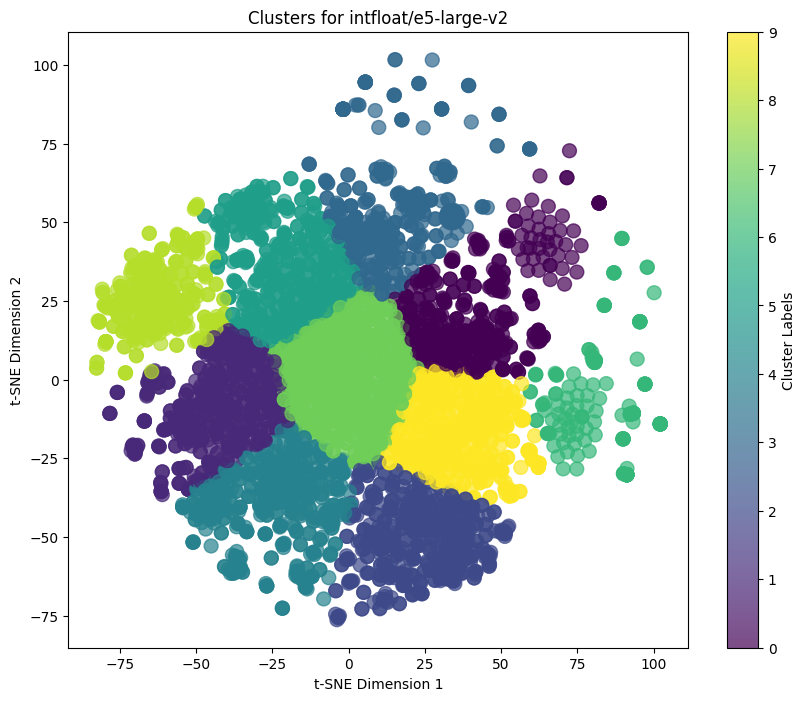


Processing model: sentence-transformers/all-mpnet-base-v2
Model: sentence-transformers/all-mpnet-base-v2
Average Cosine Similarity: -0.0015
Silhouette Score: 0.3670



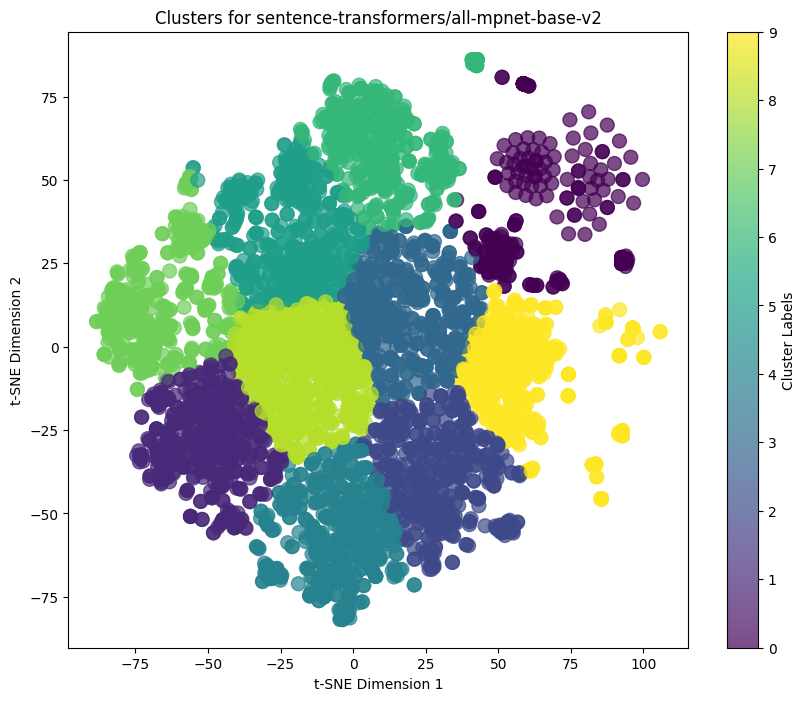


Processing model: sentence-transformers/all-MiniLM-L6-v2
Model: sentence-transformers/all-MiniLM-L6-v2
Average Cosine Similarity: 0.0071
Silhouette Score: 0.3585



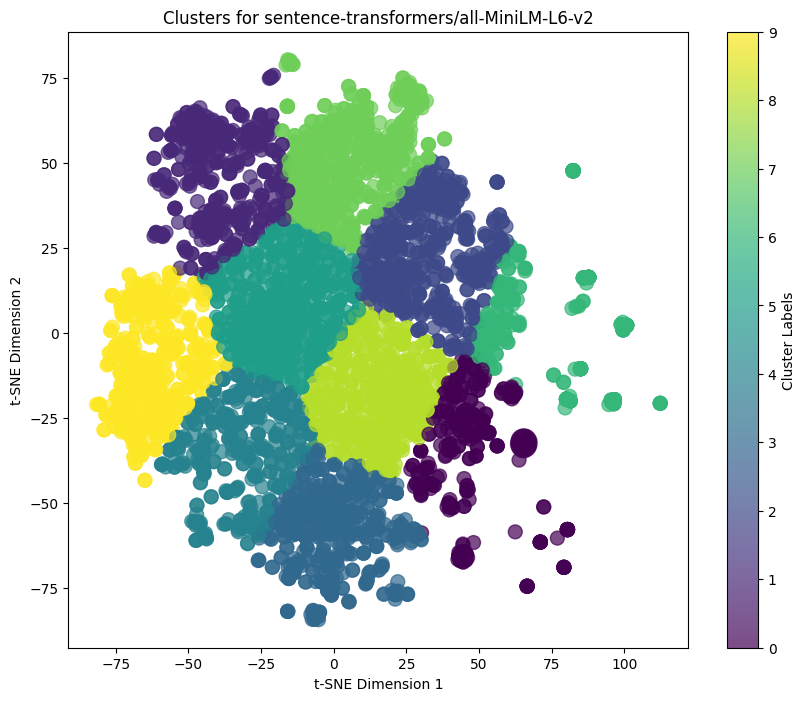


Processing model: mixedbread-ai/mxbai-embed-large-v1
Model: mixedbread-ai/mxbai-embed-large-v1
Average Cosine Similarity: -0.0086
Silhouette Score: 0.3575



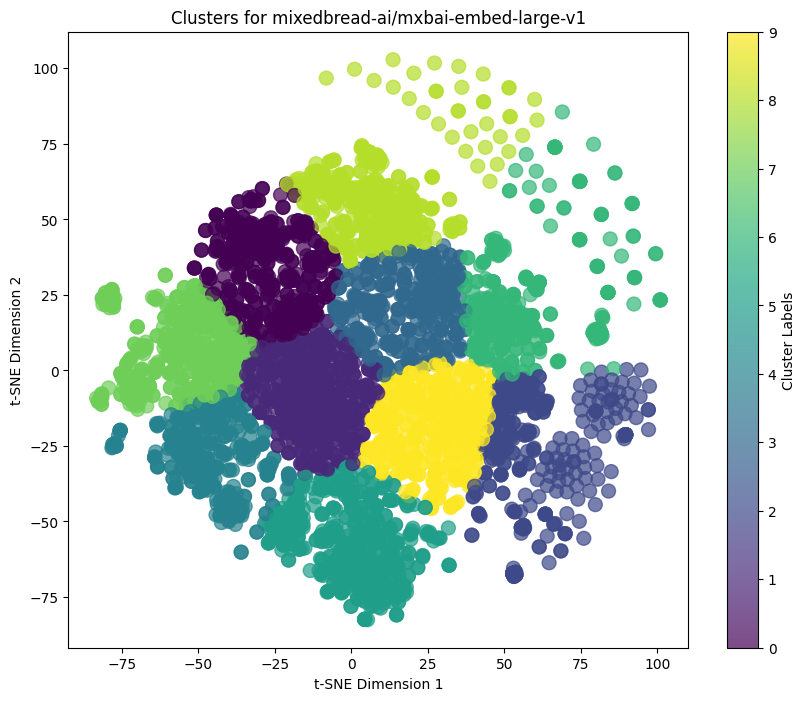

                                     Model  Average Cosine Similarity  \
0                     intfloat/e5-large-v2                  -0.003287   
1  sentence-transformers/all-mpnet-base-v2                  -0.001465   
2   sentence-transformers/all-MiniLM-L6-v2                   0.007128   
3       mixedbread-ai/mxbai-embed-large-v1                  -0.008622   

   Silhouette Score  
0          0.346173  
1          0.366963  
2          0.358462  
3          0.357457  


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Store similarity and clustering results
similarity_results = {}

for model_name in reduced_embeddings.keys():
    print(f"\nProcessing model: {model_name}")

    # Extract reduced embeddings
    job_embeddings = reduced_embeddings[model_name]["job_embeddings"]
    competency_embeddings = reduced_embeddings[model_name]["competency_embeddings"]

    # Compute cosine similarity between job postings and competencies
    similarity_matrix = cosine_similarity(job_embeddings, competency_embeddings)

    # Compute average similarity per job posting
    avg_similarity_per_job = similarity_matrix.mean(axis=1)

    # Compute overall average similarity
    overall_avg_similarity = np.mean(avg_similarity_per_job)

    # Perform clustering (K-Means)
    kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(job_embeddings)

    # Compute silhouette score
    sil_score = silhouette_score(job_embeddings, cluster_labels)

    # Store results
    similarity_results[model_name] = {
        "similarity_matrix": similarity_matrix,
        "avg_similarity_per_job": avg_similarity_per_job,
        "overall_avg_similarity": overall_avg_similarity,
        "silhouette_score": sil_score
    }

    # Print results
    print(f"Model: {model_name}")
    print(f"Average Cosine Similarity: {overall_avg_similarity:.4f}")
    print(f"Silhouette Score: {sil_score:.4f}\n")

    # Plot Clusters
    plt.figure(figsize=(10, 8))
    plt.scatter(job_embeddings[:, 0], job_embeddings[:, 1], c=cluster_labels, cmap='viridis', s=100, alpha=0.7)
    plt.colorbar(label="Cluster Labels")
    plt.title(f"Clusters for {model_name}")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

# Convert results to DataFrame for comparison
df_similarity = pd.DataFrame({
    "Model": list(similarity_results.keys()),
    "Average Cosine Similarity": [similarity_results[m]["overall_avg_similarity"] for m in similarity_results],
    "Silhouette Score": [similarity_results[m]["silhouette_score"] for m in similarity_results]
})

# Display results in text format
print(df_similarity)
